<a href="https://colab.research.google.com/github/Hit07/ML-DL-Torch/blob/main/FoodVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CUSTOM DATASET

> Our dataset is a subset of the Food101 dataset.
Food101 starts 101 different classes of food and 1000 images per class (750
training, 250 testing)

> Our dataset starts with 3 classes of food and only 10% of the images (75 training,
25 testing)

> Why do this?
When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
The whole point is to speed up how fast you can experiment.

# Import Statements

In [87]:
import torch
from torch import nn
from pathlib import Path
import requests
import zipfile
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
# Transform image
from torchvision import datasets,transforms
from typing import Tuple,Dict,List



# Downloading the datasets

In [88]:
data_path = Path("data/")
images_path = data_path / 'pizza_steak_sushi'

if images_path.is_dir():
  print(f'{images_path} directory already exists, skipping download')
else:
  print(f"{images_path} directory doesn't exist")
  images_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/'pizza_steak_sushi.zip','wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    request.raise_for_status
    print("Downlaoding the zip file")
    f.write(request.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zip_f:
    print("Extracting zipfile")
    zip_f.extractall(images_path)


data/pizza_steak_sushi directory already exists, skipping download


In [89]:
# Data Exploration and Data Cleaning

def walk_through_dir(dir_path):
  ''' Walks through the dir_path and returns the content'''
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} and {len(filenames)} images in {dirpath}')

walk_through_dir(images_path)

There are 2 and 0 images in data/pizza_steak_sushi
There are 3 and 0 images in data/pizza_steak_sushi/train
There are 0 and 75 images in data/pizza_steak_sushi/train/steak
There are 0 and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 and 0 images in data/pizza_steak_sushi/test
There are 0 and 19 images in data/pizza_steak_sushi/test/steak
There are 0 and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 and 25 images in data/pizza_steak_sushi/test/pizza


In [90]:
train_dir = images_path / 'train'
test_dir = images_path / 'test'

train_dir,test_dir



(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing and image
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [91]:
torch.manual_seed(42)
images_list  = list(images_path.glob('*/*/*.jpg'))
random_image_path = random.choice(images_list)
random_image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'Image Path: {random_image_path}\nImage class: {random_image_class}\nImage height: { img.height}\nImage width: { img.width}\n')

Image Path: data/pizza_steak_sushi/train/pizza/1044789.jpg
Image class: pizza
Image height: 512
Image width: 512



(-0.5, 511.5, 511.5, -0.5)

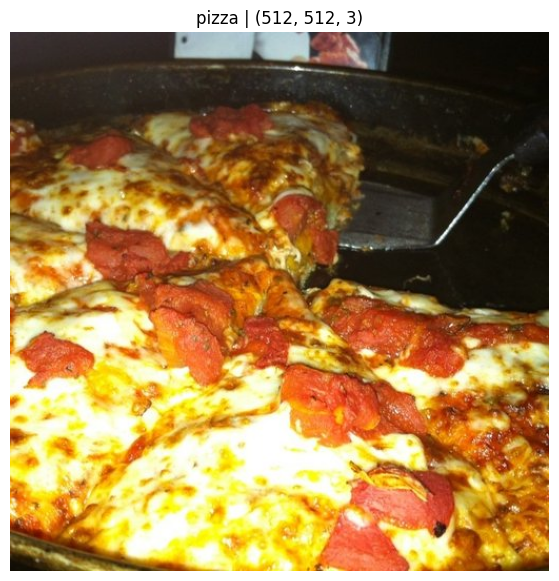

In [92]:
# Visualize the Data
image_as_np = np.array(img)
plt.figure(figsize=(10,7))
plt.imshow(image_as_np)
plt.title(f'{random_image_class} | {image_as_np.shape}')
plt.axis('off')

# Transfoming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images ).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data`.
DataLoader, we'll call these `Dataset` and `Dataloader`

In [93]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizonatal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [94]:
data_transform(img).shape

torch.Size([3, 64, 64])

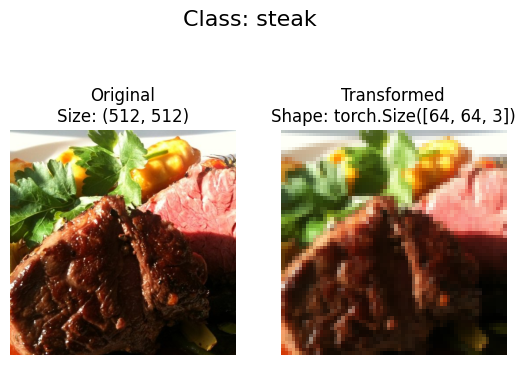

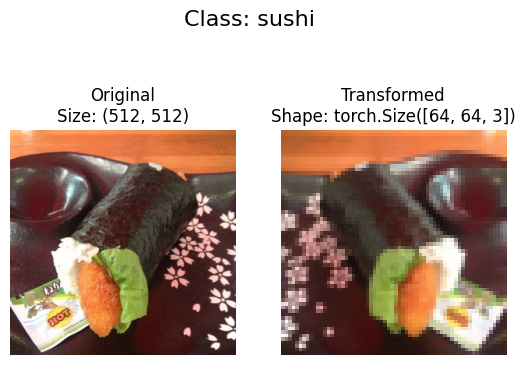

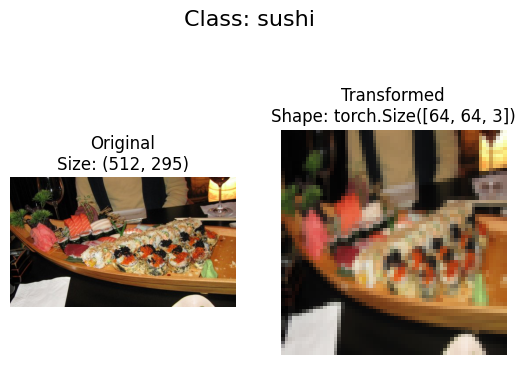

In [95]:
def plot_transformed_images(image_paths:list,transform,n=3,seed=None):
  '''
  Selects random images from a path of images and load/transforms them to
  plots the original v/s transformed versions.
  '''
  if seed:
    random.seed (seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open (image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax [0].imshow (f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis (False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Matplotlib takes in the for HWC
      ax[1].imshow (transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis ("off")
      fig.suptitle(f"Class: {image_path.parent.stem}" ,fontsize=16)


plot_transformed_images(images_list,data_transform,seed=12)



# Loading Image data using `ImageFolder`
> We can load image classification data using
`torchvision.datasets.ImageFolder`

In [96]:
train_data = datasets.ImageFolder(root=train_dir, # image_paths/'train'
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, # image_paths/'test'
                                  transform=data_transform,
                                  target_transform=None)

In [97]:
print(train_data.class_to_idx)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [98]:
print(train_data.classes)

['pizza', 'steak', 'sushi']


## Loading Images data with a custom dataset--> Proxy for   `ImageFolder`

#### Creating a helper function to get class names
We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them |

In [99]:
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [100]:
def return_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
  ''' Finds the class as replacement for ImageFolder attribute using os.scandir()
  and returns tuple and dict of classes
  '''
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  if not classes:
    raise FileNotFoundError("Could not find any classes in dir")

  class_to_indx = {class_name:i for i,class_name in enumerate(classes)}

  return classes,class_to_indx

In [101]:
return_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom 'Dataset' to replicate 'ImageFolder'
To create our own custom dataset, we want to:
1. Subclass "torch.utils.data.Dataset™
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `len()`—
method to return the length of our dataset
6. Overwrite the
`_getitem()_` method to return a given sample when passed ar
index

In [102]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset
from pathlib import Path

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset) :
# 2. Initialize our custom dataset
  def __init__(self,targ_dir: str, transform=None) :
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_indx = return_classes(targ_dir)
    # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)
    # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples."""
    return len(self.paths)

  # 6. Overwrite __getitem__() method  to return a particular sample
  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_indx[class_name]

    if self.transform:
      return self.transform(img),class_idx # return data,label(X,y)
    else:
      return img,class_idx # return untranformed image and label



In [103]:
from torchvision import transforms
train_tranforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_tranforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [104]:
train_data_custom = ImageFolderCustom(train_dir,train_tranforms)
test_data_custom = ImageFolderCustom(test_dir,test_tranforms)


train_data_custom.transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

# Data Loader

It converts datasets into iterables and we can customise the batch_size

In [105]:
import os
os.cpu_count()

2

In [108]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=32,
                              shuffle=True,
                              num_workers=os.cpu_count())
test_dataloder_custom = DataLoader(dataset=test_data_custom,
                            batch_size=32,
                            shuffle=False)

train_features_batch,train_labels_batch = next(iter(train_dataloader_custom))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Image size: torch.Size([3, 64, 64])
Label: 1, label size: torch.Size([])


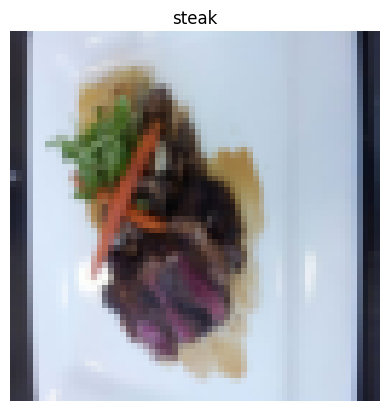

In [109]:
torch.manual_seed(11)
random_indx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_indx],train_labels_batch[random_indx]

plt.imshow(img.permute(2,1,0).squeeze())
plt.title(train_data.classes[label])
plt.axis (False)
print (f"Image size: {img.shape}" )
print(f"Label: {label}, label size: {label.shape}")

# Data Agumentation

The process of artificially adding diversity to the training data


In [117]:
train_agumen = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
]
)

test_agumen = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
]
)

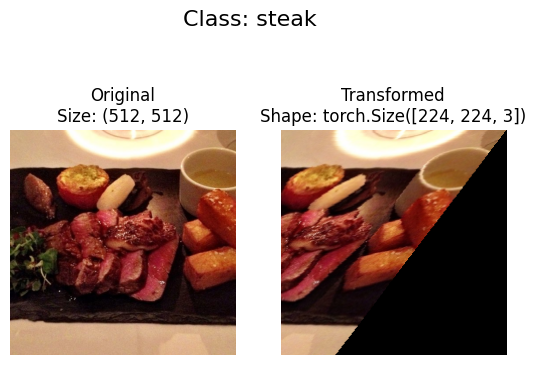

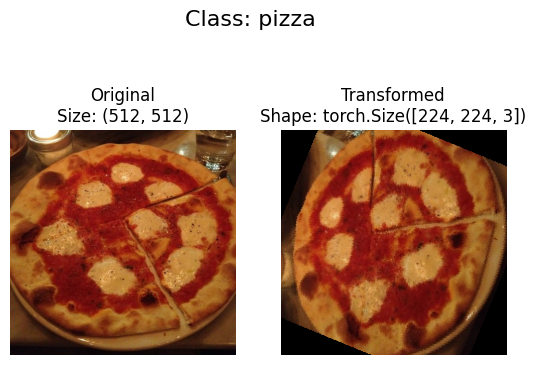

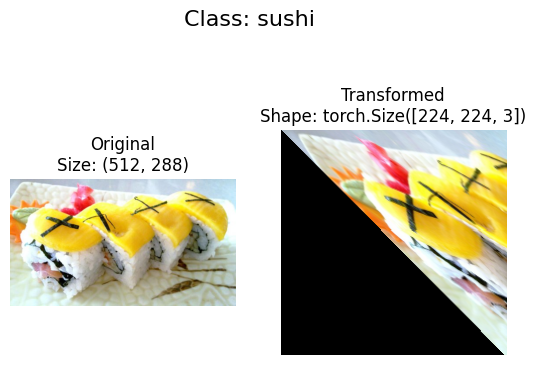

In [118]:
plot_transformed_images(images_list,train_agumen)